## Lec 5. UNet

- 生成式模型
    - 生成对抗网络 `GAN (Generative Adversarial Networks)`
    - Diffusion 扩散模型
        - `UNet`
        - `CLIP`
        - `VAE`

In [59]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [61]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### 5.1 图像数据集

In [64]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [66]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

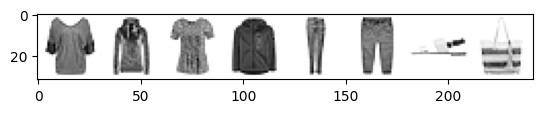

In [68]:
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

### 5.2 添加噪声

In [71]:
def corrupt(x, amount):
    """ 图像添加噪声函数 """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return (1 - amount) * x + amount * noise

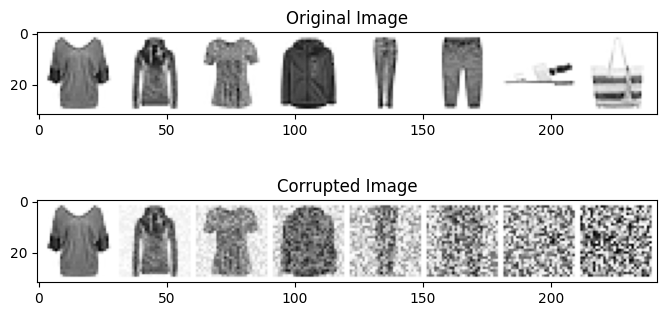

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(8, 4)) #2行1列
axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

amount = torch.linspace(0, 1, x.shape[0]) #生成0-1的10个数
corrupted_x = corrupt(x, amount)
axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(corrupted_x)[0], cmap="Greys")

### 5.3 BasicUNet 基础UNet

- 下采样
- 上采样


In [76]:
class BasicUNet(nn.Module):
    """ 基础UNet网络 """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # 下采样 - 通道数增多，特征图缩小
        self.down_layers = nn.ModuleList([nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),  #28+2*2-5+1还是28
                                          nn.Conv2d(32, 64, kernel_size=5, padding=2), 
                                          nn.Conv2d(64, 64, kernel_size=5, padding=2)])
        # 上采样 - 通道数减少，特征图增大
        self.up_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=5, padding=2), 
                                        nn.Conv2d(64, 32, kernel_size=5, padding=2), 
                                        nn.Conv2d(32, out_channels, kernel_size=5, padding=2)])
        
        self.activation = nn.ReLU()
        self.downscale = nn.MaxPool2d(kernel_size=2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        """ 前向传播方法 """
        hidden = []  # 用来存储下采样过程的中间结果 [特征图]
        for idx, layer in enumerate(self.down_layers):
            x = self.activation(layer(x))
            if idx < 2:
                hidden.append(x)
                x = self.downscale(x)
                
        for idx, layer  in enumerate(self.up_layers):
            if idx > 0:
                x = self.upscale(x)
                x = x + hidden.pop() 
            x = self.activation(layer(x))
        return x

In [78]:
model = BasicUNet(1, 1)
model

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (activation): ReLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [80]:
output = model(x)
output.shape, x.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

### 5.4 模型训练

In [83]:
amount = torch.rand(x.shape[0])
amount

tensor([0.8053, 0.3896, 0.6343, 0.4786, 0.5196, 0.8975, 0.1742, 0.5067])

In [85]:
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0
    for x, _ in dataloader:
        amount = torch.rand(x.shape[0]).to(device)
        corrupted_x = corrupt(x.to(device), amount)
        
        y_hat = model(corrupted_x)
        loss = loss_func(y_hat, x.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [87]:
model = BasicUNet(1, 1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [89]:
n_epoch = 50

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 0.07
Epoch 2 loss: 0.0411
Epoch 3 loss: 0.0326
Epoch 4 loss: 0.0291
Epoch 5 loss: 0.0276
Epoch 6 loss: 0.0266
Epoch 7 loss: 0.027
Epoch 8 loss: 0.0249
Epoch 9 loss: 0.0264
Epoch 10 loss: 0.0255
Epoch 11 loss: 0.0254
Epoch 12 loss: 0.0242
Epoch 13 loss: 0.0235
Epoch 14 loss: 0.0237
Epoch 15 loss: 0.0234
Epoch 16 loss: 0.023
Epoch 17 loss: 0.0226
Epoch 18 loss: 0.0228
Epoch 19 loss: 0.0219
Epoch 20 loss: 0.0229
Epoch 21 loss: 0.022
Epoch 22 loss: 0.0223
Epoch 23 loss: 0.0212
Epoch 24 loss: 0.0215
Epoch 25 loss: 0.0216
Epoch 26 loss: 0.0212
Epoch 27 loss: 0.0213
Epoch 28 loss: 0.0215
Epoch 29 loss: 0.0205
Epoch 30 loss: 0.0208
Epoch 31 loss: 0.0212
Epoch 32 loss: 0.0211
Epoch 33 loss: 0.02
Epoch 34 loss: 0.0212
Epoch 35 loss: 0.0207
Epoch 36 loss: 0.0203
Epoch 37 loss: 0.0205
Epoch 38 loss: 0.021
Epoch 39 loss: 0.0206
Epoch 40 loss: 0.0209
Epoch 41 loss: 0.0206
Epoch 42 loss: 0.0205
Epoch 43 loss: 0.0196
Epoch 44 loss: 0.0197
Epoch 45 loss: 0.0202
Epoch 46 loss: 0.0202
Epoch

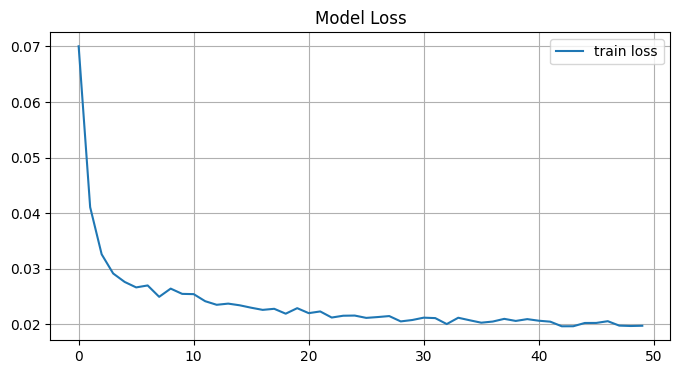

In [91]:
plt.figure(figsize = (8, 4))
plt.plot(train_loss, label = 'train loss')
plt.title('Model Loss')
plt.grid()
plt.legend()
plt.show()

---

**测试不加入 hidden 参照的效果**

In [67]:
class BasicUNet(nn.Module):
    """ 基础UNet网络 """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # 下采样 - 通道数增多，特征图缩小
        self.down_layers = nn.ModuleList([nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),  #28+2*2-5+1还是28
                                          nn.Conv2d(32, 64, kernel_size=5, padding=2), 
                                          nn.Conv2d(64, 64, kernel_size=5, padding=2)])
        # 上采样 - 通道数减少，特征图增大
        self.up_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=5, padding=2), 
                                        nn.Conv2d(64, 32, kernel_size=5, padding=2), 
                                        nn.Conv2d(32, out_channels, kernel_size=5, padding=2)])
        
        self.activation = nn.ReLU()
        self.downscale = nn.MaxPool2d(kernel_size=2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        """ 前向传播方法 """
        hidden = []  # 用来存储下采样过程的中间结果 [特征图]
        for idx, layer in enumerate(self.down_layers):
            x = self.activation(layer(x))
            if idx < 2:
                hidden.append(x)
                x = self.downscale(x)
                
        for idx, layer  in enumerate(self.up_layers):
            if idx > 0:
                x = self.upscale(x)
            #     x = x + hidden.pop() 
            x = self.activation(layer(x))
        return x

In [69]:
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0
    for x, _ in dataloader:
        amount = torch.rand(x.shape[0]).to(device)
        corrupted_x = corrupt(x.to(device), amount)
        
        y_hat = model(corrupted_x)
        loss = loss_func(y_hat, x.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [71]:
model = BasicUNet(1, 1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [73]:
n_epoch = 50

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 0.1946
Epoch 2 loss: 0.1224
Epoch 3 loss: 0.0995
Epoch 4 loss: 0.0838
Epoch 5 loss: 0.063
Epoch 6 loss: 0.0512
Epoch 7 loss: 0.0447
Epoch 8 loss: 0.0414
Epoch 9 loss: 0.0397
Epoch 10 loss: 0.0387
Epoch 11 loss: 0.0368
Epoch 12 loss: 0.0355
Epoch 13 loss: 0.0346
Epoch 14 loss: 0.0341
Epoch 15 loss: 0.0337
Epoch 16 loss: 0.0326
Epoch 17 loss: 0.032
Epoch 18 loss: 0.0315
Epoch 19 loss: 0.0317
Epoch 20 loss: 0.031
Epoch 21 loss: 0.031
Epoch 22 loss: 0.0305
Epoch 23 loss: 0.0297
Epoch 24 loss: 0.0291
Epoch 25 loss: 0.0291
Epoch 26 loss: 0.0295
Epoch 27 loss: 0.0291
Epoch 28 loss: 0.0281
Epoch 29 loss: 0.0283
Epoch 30 loss: 0.0282
Epoch 31 loss: 0.0279
Epoch 32 loss: 0.0282
Epoch 33 loss: 0.028
Epoch 34 loss: 0.0273
Epoch 35 loss: 0.0272
Epoch 36 loss: 0.0268
Epoch 37 loss: 0.027
Epoch 38 loss: 0.0271
Epoch 39 loss: 0.0268
Epoch 40 loss: 0.0263
Epoch 41 loss: 0.0263
Epoch 42 loss: 0.0261
Epoch 43 loss: 0.026
Epoch 44 loss: 0.026
Epoch 45 loss: 0.0263
Epoch 46 loss: 0.026
Epoch 

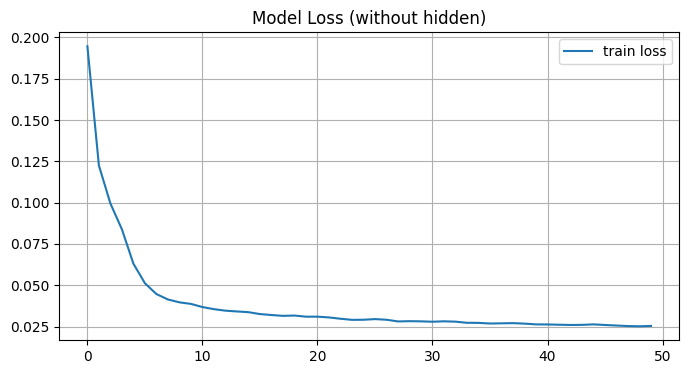

In [75]:
plt.figure(figsize = (8, 4))
plt.plot(train_loss, label = 'train loss')
plt.title('Model Loss (without hidden)')
plt.grid()
plt.legend()
plt.show()

可见效果没有加入hidden后的好

---

以下采用的均是有hidden的model

In [93]:
model = model.cpu()

In [99]:
amount = torch.linspace(0, 1, x.shape[0])
corrupted_x = corrupt(x, amount)

with torch.no_grad(): #内部所写代码不会影响模型内部参数变动
    y_hat = model(corrupted_x)

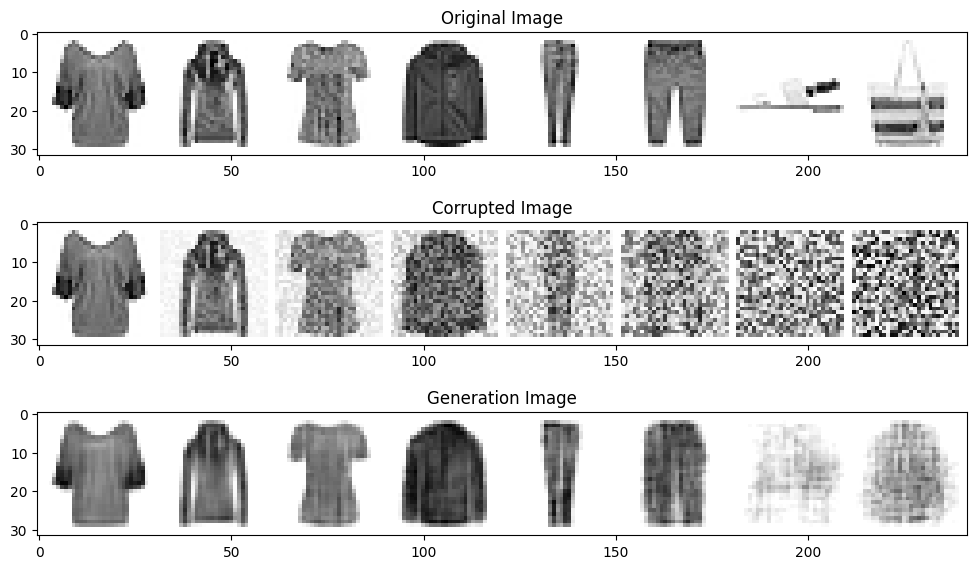

In [101]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7)) #2行1列
axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

amount = torch.linspace(0, 1, x.shape[0]) #生成0-1的10个数
corrupted_x = corrupt(x, amount)
axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(corrupted_x)[0], cmap="Greys")

axs[2].set_title("Generation Image")
axs[2].imshow(torchvision.utils.make_grid(y_hat)[0], cmap="Greys")

### 5.5 采样sample

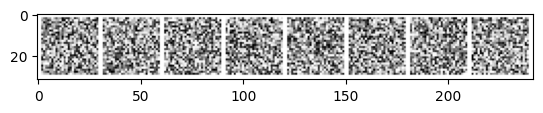

In [139]:
n_steps = 5

noise = torch.rand(8, 1, 28, 28)
plt.imshow(torchvision.utils.make_grid(noise)[0], cmap="Greys")

In [141]:
step_history = [noise]
output_history = []

In [143]:
x = torch.rand(8, 1, 28, 28)

In [145]:
n_steps = 5

for i in range(n_steps):
    with torch.no_grad():
        y_hat = model(x)

    output_history.append(y_hat)
    mix_factor = 1 / n_steps
    x = (1 - mix_factor) * x + mix_factor * y_hat
    step_history.append(x)

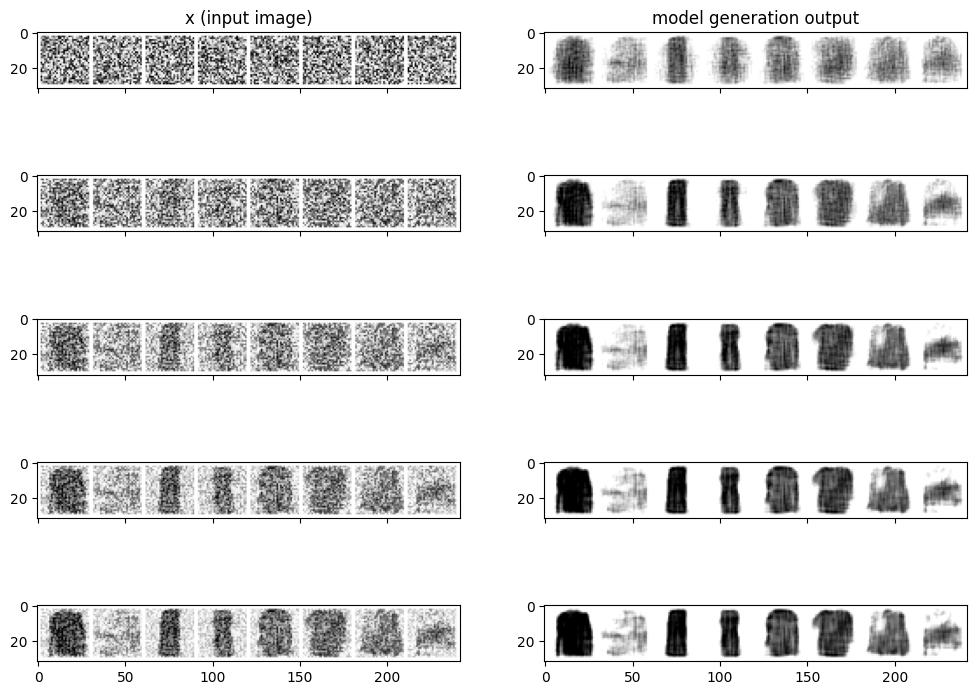

In [147]:
fig, axs = plt.subplots(n_steps, 2, figsize=(12,9),sharex=True) #共享x轴
axs[0, 0].set_title('x (input image)')
axs[0, 1].set_title('model generation output')

for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1),cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(output_history[i])[0].clip(0,1),cmap='Greys')